In [85]:
# from google.colab import drive
# drive.mount('/content/drive')

In [86]:
# cd /content/drive/'My Drive'/PredictHousePrice

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import datetime 

import warnings
warnings.filterwarnings('ignore')

In [88]:
import import_ipynb
from lib_final import *

In [89]:
# Link crawl data: https://ancu.me/cho-thue-nha-tro-phong-tro-thanh-pho-ho-chi-minh/t1
train_df = pd.read_csv('clean_data.csv')
train_df_temp = train_df.copy()
train_df_temp.head()

,Id,Title,Price,Square,District,City,Date
0,329,Tìm người ở ghép phòng trọ gần ngã 3 Lũy Bán B...,8.4,NaN,Tân Phú,Hồ Chí Minh,2018-05-17
1,1110,"Cho thuê phòng trọ 25m2, giờ tự do hẻm 137 Trị...",2.5,25.0,Tân Phú,Hồ Chí Minh,2018-05-14
2,1114,Chuyên cho thuê CH Era Town có thể dọn vào ở l...,2.0,15.0,Quận 7,Hồ Chí Minh,2018-05-14
3,1275,"Phòng gác lửng, máy lạnh, ban công, WC riêng, ...",3.7,NaN,Quận 7,Hồ Chí Minh,2018-05-14
4,1592,Cho thuê phòng full nội thất cho nữ trong căn ...,3.8,NaN,Nhà Bè,Hồ Chí Minh,2018-05-14


Clean data

Chỉ chọn ra các phòng trọ

In [90]:
train_df_temp = title_clean('Title', train_df_temp)

Xóa đi 2 đặc trưng City, Date và thêm vào 3 đặc trưng: isNew, hasFurniture, liveTogether

In [91]:
train_df_temp.drop('City', axis= 1, inplace = True)
train_df_temp.drop('Date', axis= 1, inplace = True)


In [92]:
train_df_temp = isNew('Title', train_df_temp)
train_df_temp = hasFurniture('Title', train_df_temp)
train_df_temp = liveTogether('Title', train_df_temp)

In [93]:
train_df_temp.head()

,Id,Title,Price,Square,District,isNew,hasFurniture,liveTogether
0,329,tìm người ở ghép phòng trọ gần ngã 3 lũy bán b...,8.4,NaN,Tân Phú,no,no,yes
1,1110,"cho thuê phòng trọ 25m2, giờ tự do hẻm 137 trị...",2.5,25.0,Tân Phú,no,no,no
2,2618,cho thuê phòng trọ mới xây tại 377/8/34 bạch đ...,3.0,20.0,Bình Thạnh,yes,no,no
3,3880,cho thuê phòng trọ mới giá rẻ đường chu văn an...,3.3,22.0,Bình Thạnh,yes,no,no
4,4182,"cho thuê phòng trọ hẻm 283 huỳnh tấn phát, kcx...",2.5,13.5,Quận 7,no,no,no


Dựa vào cột Date, xử lý thành đặc trưng số ngày đăng, để kiểm tra xem liệu giá nhà cho thuê có phụ thuộc vào đặc trưng NumDay không?

In [94]:
# chuyển kiểu dữ liệu của cột Date sang kiểu data time để dễ tính số ngày đã đăng bài cho thuê
# train_df_temp["Date"] = train_df_temp["Date"].str.replace('\n','')
# train_df_temp["Date"] = pd.to_datetime(train_df_temp["Date"],format = "%d/%m/%Y ",errors = 'coerce')

In [95]:
#Lấy ngày hôm nay
# today = date.today()
# today_column = pd.Series(np.full(len(train_df_temp.index),fill_value = today))
# today_column = today_column.astype('datetime64[ns]')
# train_df_temp["Num_day"] = (today_column - train_df_temp["Date"]).dt.days
# train_df_temp.drop(train_df_temp[train_df_temp["Num_day"] < 0].index, inplace = True)

In [96]:
# Lúc thu thập dữ liệu, có những chỗ 3 triệu 5 thì họ ghi 3.5, có chỗ ghi 3.500.000, nên cần xử lý.
train_df_temp[train_df_temp["Price"] > 100]

,Id,Title,Price,Square,District,isNew,hasFurniture,liveTogether
696,1435239,"cho thuê phòng trọ đầy đủ tiện ích, số 23 - 25...",4500.0,25.0,Tân Bình,no,no,no
741,1450703,"cho thuê phòng trọ 27m2 đường nguyễn khoái, ph...",3000000.0,27.0,Quận 4,no,no,no
785,1478477,"phòng trọ cho thuê,giá 1tr6/tháng.phòng riêng,...",1600000.0,16.0,Gò Vấp,no,no,no
787,1479914,phòng trọ cho thuê đường nguyễn ảnh thủ quận 1...,1500000.0,18.0,Quận 12,no,no,no


In [97]:
train_df_temp = cleanPrice('Price', train_df_temp)

In [98]:
train_df_temp[train_df_temp["Price"] > 100]

,Id,Title,Price,Square,District,isNew,hasFurniture,liveTogether


In [99]:
train_df_temp.head()

,Id,Title,Price,Square,District,isNew,hasFurniture,liveTogether
0,329,tìm người ở ghép phòng trọ gần ngã 3 lũy bán b...,8.4,NaN,Tân Phú,no,no,yes
1,1110,"cho thuê phòng trọ 25m2, giờ tự do hẻm 137 trị...",2.5,25.0,Tân Phú,no,no,no
2,2618,cho thuê phòng trọ mới xây tại 377/8/34 bạch đ...,3.0,20.0,Bình Thạnh,yes,no,no
3,3880,cho thuê phòng trọ mới giá rẻ đường chu văn an...,3.3,22.0,Bình Thạnh,yes,no,no
4,4182,"cho thuê phòng trọ hẻm 283 huỳnh tấn phát, kcx...",2.5,13.5,Quận 7,no,no,no


In [100]:
# Xóa những dòng Square = null
train_df_temp = train_df_temp[train_df_temp["Square"].notna()]

Xác định biến Categorical/Numeric

In [101]:
train_df_temp.columns

Index(['Id', 'Title', 'Price', 'Square', 'District', 'isNew', 'hasFurniture',
       'liveTogether'],
      dtype='object')

In [102]:
# Biến Categorical
cat_var = ['District', 'isNew', 'hasFurniture', 'liveTogether']
# Biến numerical
num_vars = ['Price', 'Square']

In [103]:
# Numeric variables 
'''
result_list=[]
for var in num_vars:
    result = univariate_cont_analysis(var,train_df_temp)
    result_list.append(result)
df_result = pd.DataFrame(result_list,columns=['mean','median','mode','max_val','min_val','range_val','variance','skewness','kurtosis'],
                  index=num_vars)
df_result
'''

,mean,median,mode,max_val,min_val,range_val,variance,skewness,kurtosis
Price,3.213403,3.0,"0 3.0 Name: Price, dtype: float64",50.0,0.002,49.998,5.394197,10.960109,198.752559
Square,23.222028,22.0,"0 20.0 Name: Square, dtype: float64",200.0,5.000,195.000,106.201812,6.044738,90.089518


Ta vẽ displot để xem dữ liệu có theo dạng phân phối chuẩn không, cũng như tìm các outliers

<AxesSubplot: xlabel='Square', ylabel='Density'>

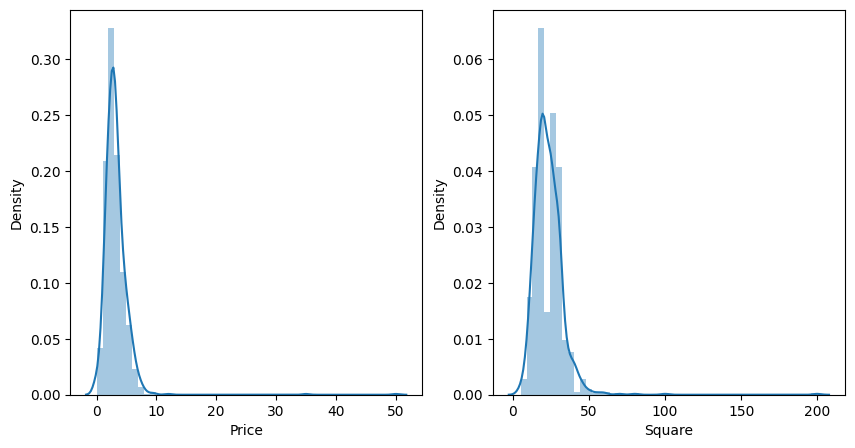

In [104]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
sns.distplot(train_df_temp[num_vars[0]].dropna())
plt.subplot(122)
sns.distplot(train_df_temp[num_vars[1]].dropna())


In [105]:
train_df_temp = train_df_temp[train_df_temp['Price'] < 10]
train_df_temp = train_df_temp[train_df_temp['Square'] < 50]

Xem sự phân bố giữa các giá trị của từng feature: District, isNew, hasFurniture, liveTogether để xem dữ liệu có bias không.

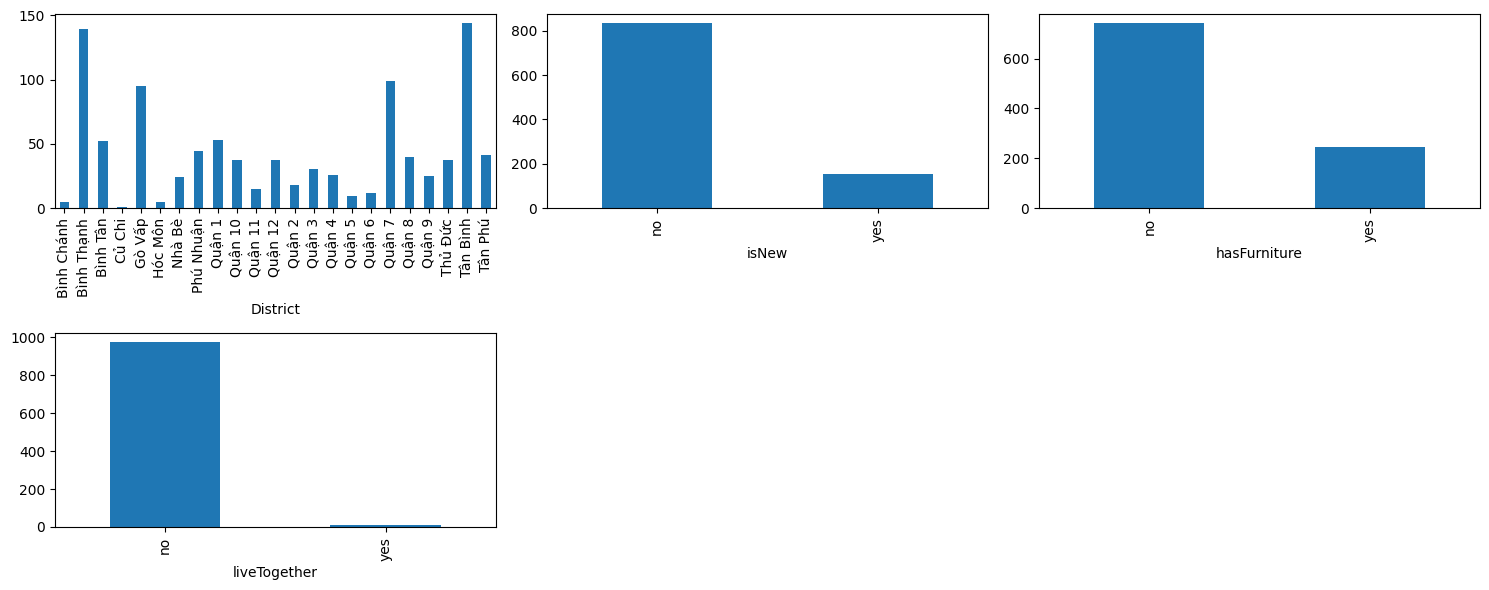

In [107]:
#Visualization - Value_count - barplot
def visualize_cat_value_count(cat_var, train_df_temp):
    if len(cat_var)%3 == 0:
        n = len(cat_var)/3
    else:
        n = len(cat_var)//3 + 1
    plt.figure(figsize=(15,6))
    for i in range (1,len(cat_var)+1):
        count = train_df_temp.groupby(train_df_temp[cat_var[i-1]].dropna()).size()
        #print(count)
        plt.subplot(n,3,i)
        count.plot.bar()
    plt.tight_layout()
    plt.show()
visualize_cat_value_count(cat_var, train_df_temp)

Ta xác định mức độ tương quan giữa giá và diện tích

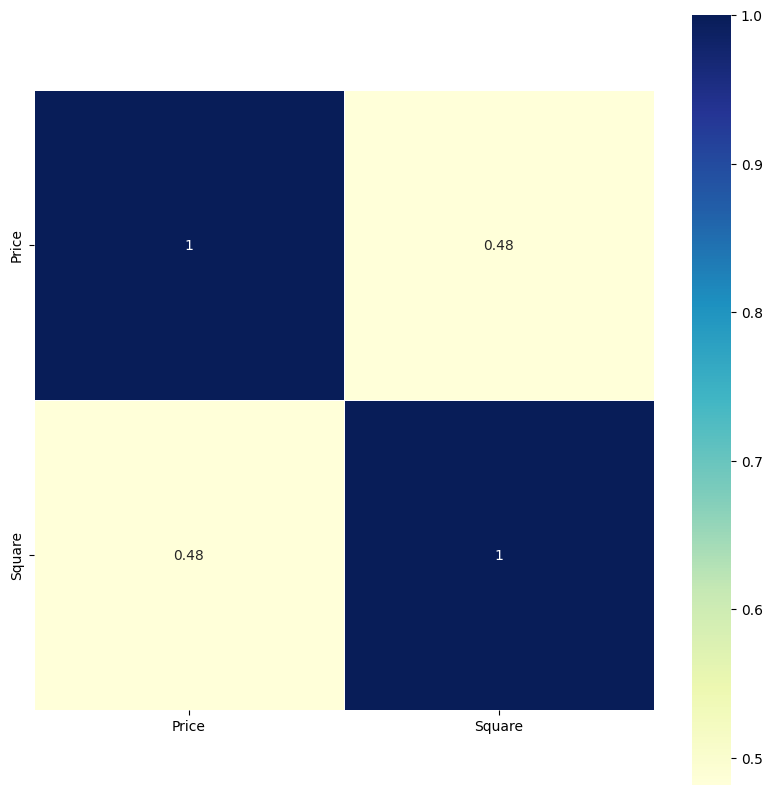

In [108]:
#Vẽ heatmap để xác định những input tương quan với 'Price', và những input độc lập với nhau 
plt.figure(figsize=(10,10))
sns.heatmap(train_df_temp[num_vars].corr(), cmap="YlGnBu", annot=True,square=True, linewidths=.5)
plt.show() 

In [109]:
#ANOVA test
import statsmodels.api as sm
from statsmodels.formula.api import ols
#Anova Test -> tìm ra biến phân loại phụ thuộc với 'Gia'
def anova_test(cat_var, output, df):
    dependent_cat_list = []
    for var in cat_var:
        model = ols(' '+ output +'~ C(' + var + ')', df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        #display(anova_table)
        if anova_table['PR(>F)'][0] < 0.05:
            #print(var,'p-value:',anova_table['PR(>F)'][0])
            #print('==> Dependent (Reject H0)')
            dependent_cat_list.append(var)
    return dependent_cat_list

anova_test(cat_var,'Price', train_df_temp)

['District', 'hasFurniture', 'liveTogether']

In [110]:
import scipy
#Chi-square test
from scipy.stats import chi2_contingency, chi2

#categgorical - categorical
def chi2_test(cat_var,df):
    chi2_test_df=pd.DataFrame(index=cat_var,columns=cat_var)
    alpha = 0.05

    for i in range (len(cat_var)):
        for j in range(i+1,len(cat_var)):
            table = pd.crosstab(df[cat_var[i]],df[cat_var[j]])
            stat, p, dof, expected = chi2_contingency(table)
            #print('\n*** significance = %.3f, p_value = %.3f' %(alpha,p))
            if p < alpha:
                #print(cat_var[i],'&',cat_var[j],'==> Dependent (Reject H0)')
                chi2_test_df.loc[cat_var[i],cat_var[j]]='Dependent'
            else:
                #print(cat_var[i],'&',cat_var[j],'==> Independent (Fail to Reject H0)')
                chi2_test_df.loc[cat_var[i],cat_var[j]]='Independent'
    return chi2_test_df 

#Chi2 Test -> tìm ra các biến category độc lập
chi2_test(cat_var,train_df_temp)

,District,isNew,hasFurniture,liveTogether
District,NaN,Independent,Dependent,Independent
isNew,NaN,NaN,Independent,Independent
hasFurniture,NaN,NaN,NaN,Independent
liveTogether,NaN,NaN,NaN,NaN


Quyết định sử dụng các biến: Square, District, isNew, hasFurniture, liveTogether 

In [111]:
df_new = train_df_temp[['Price', 'Square', 'District', 'isNew', 'hasFurniture', 'liveTogether']]
df_new.head()

,Price,Square,District,isNew,hasFurniture,liveTogether
1,2.5,25.0,Tân Phú,no,no,no
2,3.0,20.0,Bình Thạnh,yes,no,no
3,3.3,22.0,Bình Thạnh,yes,no,no
4,2.5,13.5,Quận 7,no,no,no
5,5.6,30.0,Bình Thạnh,no,yes,no


Build model

In [112]:
# Split train/test và Chuẩn hóa dữ liệu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [113]:
df_new = pd.get_dummies(df_new)
df_new

,Price,Square,District_Bình Chánh,District_Bình Thạnh,District_Bình Tân,District_Củ Chi,District_Gò Vấp,District_Hóc Môn,District_Nhà Bè,District_Phú Nhuận,...,District_Quận 9,District_Thủ Đức,District_Tân Bình,District_Tân Phú,isNew_no,isNew_yes,hasFurniture_no,hasFurniture_yes,liveTogether_no,liveTogether_yes
1,2.5,25.0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,1,0
2,3.0,20.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,3.3,22.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
4,2.5,13.5,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
5,5.6,30.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,1.0,12.0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
1122,5.5,33.0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0
1123,3.1,15.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1124,3.6,15.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0


In [114]:
# Split input / output
X = df_new.drop(['Price'], axis=1)   
y = df_new['Price']

In [115]:
X.shape, y.shape

((988, 30), (988,))

In [116]:
# Split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [117]:
scaler = RobustScaler()
scaler.fit_transform(X_train, y_train)

array([[ 0.9,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [-0.1,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [-0.6,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [-0.1,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [-0.3,  0. ,  0. , ...,  1. ,  0. ,  0. ],
       [-0.6,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

<AxesSubplot: xlabel='Square', ylabel='Density'>

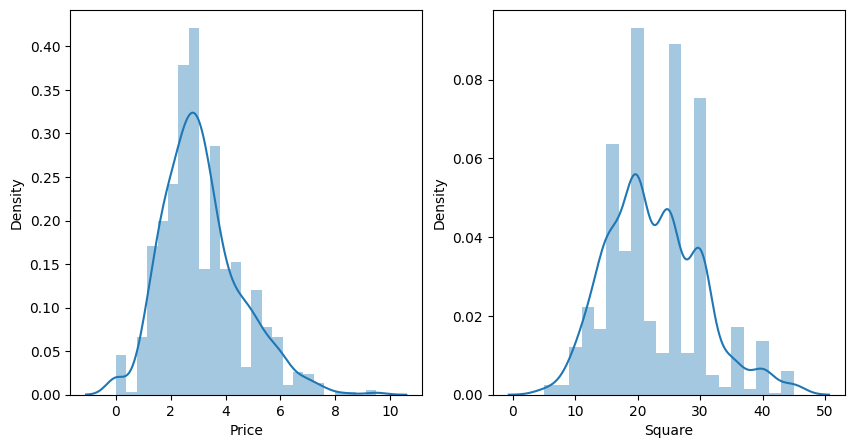

In [207]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
sns.distplot(train_df_temp[num_vars[0]].dropna())
plt.subplot(122)
sns.distplot(train_df_temp[num_vars[1]].dropna())

In [178]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import r2_score,mean_absolute_error
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [119]:
def Average_Score_Model(model, X, y, size=0.25, cv=5):
    score_train=[]
    score_test=[]
    duration=[]
    ## Thực hiện lặp cv lần, mỗi lần lặp: tách X,y -> tính accuracy của train và test, time đưa vào danh sách
    for i in range(1,cv+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size) 
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        score_train.append(model.score(X_train,y_train)) # mặc định là r-square
        score_test.append(model.score(X_test,y_test))
        duration.append((end-start)*1000)
    return np.mean(score_test),np.mean(duration) #trung bình score_train, score_test, time

In [168]:
Average_Score_Model(LinearRegression(), X_train, y_train, size=0.25, cv=10)

(-8.48738983464291e+16, 10.091829299926758)

In [169]:
Average_Score_Model(KNeighborsRegressor(), X_train, y_train, size=0.25, cv=10)

(0.3403264934093418, 5.297708511352539)

In [170]:
Average_Score_Model(RandomForestRegressor(), X_train, y_train, size=0.25, cv=10)

(0.4061067429764992, 414.5002841949463)

In [171]:
Average_Score_Model(xgb.XGBRegressor(verbosity=0), X_train, y_train, size=0.25, cv=10)

(0.37851334669494363, 341.25781059265137)

In [172]:
Average_Score_Model(Ridge(), X_train, y_train, size=0.25, cv=10)

(0.492381739034694, 6.995797157287598)

In [173]:
Average_Score_Model(Lasso(), X_train, y_train, size=0.25, cv=10)

(0.22061205204540074, 9.393525123596191)

In [206]:
model = 
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
score=r2_score(y_test,y_predict)
score

0.2112902228881538

In [ ]:
plt.plot(testY,label='True')
plt.plot(line_pre,label='Line')
plt.legend()
plt.show() 
line_score=r2_score(testY,line_pre)
line_error=mean_absolute_error(testY,line_pre)
print(line_score)
print(line_error)

Đặc trưng cần dự đoán: Price

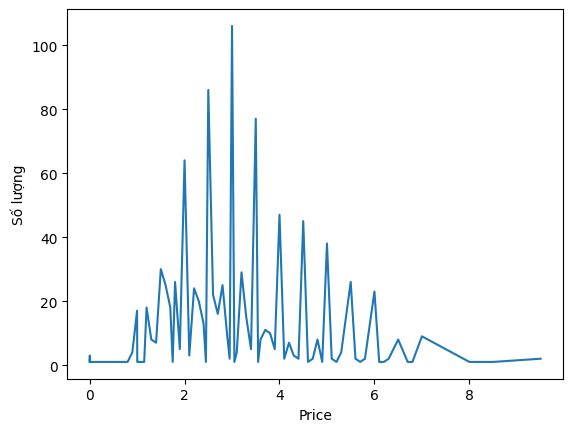

In [174]:
count_price = train_df_temp["Price"].value_counts()
count_price = count_price.sort_index()
plt.plot(count_price.index,count_price.values)
plt.xlabel('Price')
plt.ylabel('Số lượng')
plt.show()

Đa số dữ liệu có giá nhà tập trung dưới 10 triệu. Ta xét phần dữ liệu có giá < 10 triệu như sau:

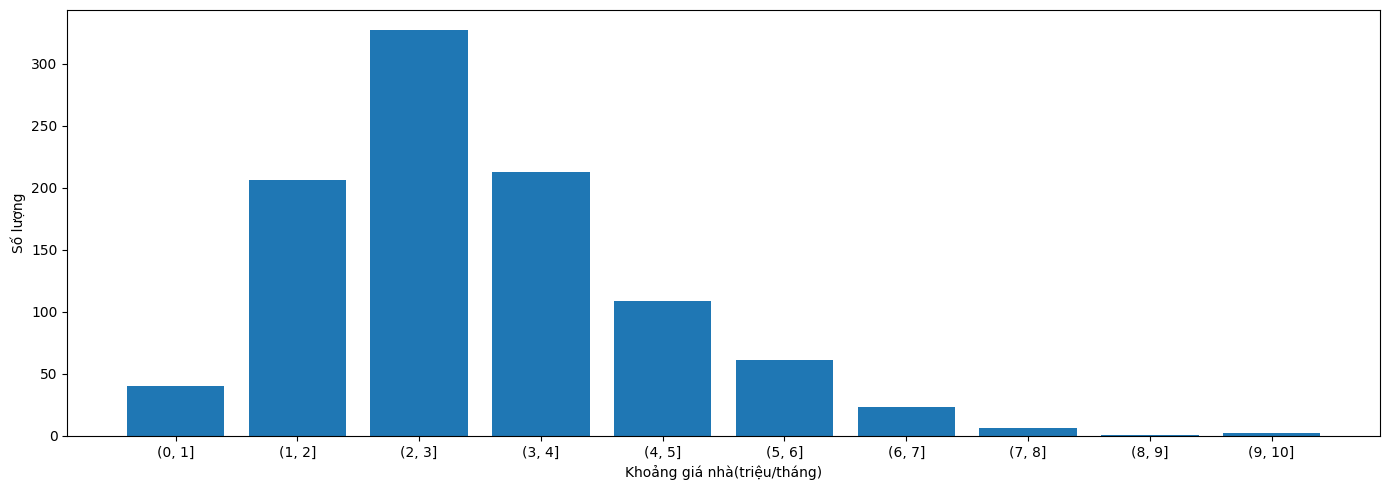

In [175]:
price_10 = train_df_temp[train_df_temp["Price"]<10]["Price"]
price_list_range = np.arange(0,11,1)

range_price_10 = pd.cut(price_10,bins = price_list_range)

count_price_10 = range_price_10.value_counts().sort_index()
count_price_10 = count_price_10.reset_index()
count_price_10.columns = ["Range","So luong"]
count_price_10["Range"] = count_price_10["Range"].astype(str)

plt.subplots(figsize = (14,5))
plt.bar(count_price_10["Range"],count_price_10["So luong"])
plt.xlabel("Khoảng giá nhà(triệu/tháng)")
plt.ylabel("Số lượng")
plt.tight_layout()
plt.show()

Xem xét giá nhà có phụ thuộc vào: 
- Square
- Type
- District
- Số ngày đăng bài

In [176]:
# Ta tính mối quan hệ giữa Price và các biến Square, Type, District và NumDay
train_df_temp.corr()['Price'].sort_values(ascending=False)[1:].head(20)

Square    0.481565
Id       -0.254526
Name: Price, dtype: float64

<AxesSubplot: xlabel='Square', ylabel='Price'>

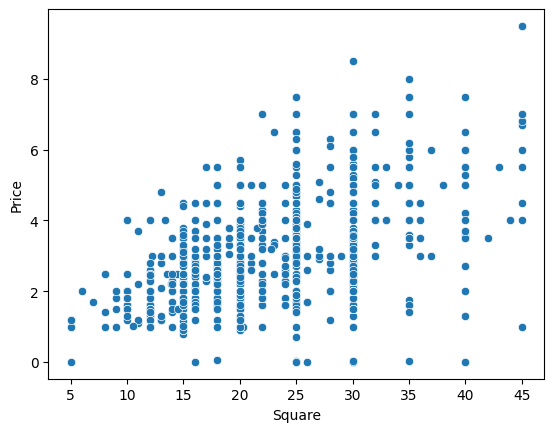

In [177]:
# Với Square
sns.scatterplot(data=train_df_temp, x='Square', y='Price')